In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import os


In [5]:
root_data_folder = "8bit_characters"
image_names = [root_data_folder + "/" + name for name in os.listdir(root_data_folder) if name.endswith(".jpg")]
print(image_names)

['8bit_characters/leonardo_5935302653_o.jpg', '8bit_characters/mysterio_5938497845_o.jpg', '8bit_characters/john-bender_5947476192_o.jpg', '8bit_characters/wheeljack_5982213732_o.jpg', '8bit_characters/spikor_5921532302_o.jpg', '8bit_characters/samus-aran-power-suit_6024447687_o.jpg', '8bit_characters/allison-reynolds_5947475934_o.jpg', '8bit_characters/calypso_5994982128_o.jpg', '8bit_characters/michaelangelo_5935302777_o.jpg', '8bit_characters/neytiri_5925081796_o.jpg', '8bit_characters/mortimer-shadow_5994422753_o.jpg', '8bit_characters/iceman_5938072442_o.jpg', '8bit_characters/lobot_5930961478_o.jpg', '8bit_characters/krista-sparks-grasshopper_5994422531_o.jpg', '8bit_characters/pee-wee-herman_5942000962_o.jpg', '8bit_characters/leeloo_5935305091_o.jpg', '8bit_characters/bamm-bamm_5991957878_o.jpg', '8bit_characters/arwen_5955334313_o.jpg', '8bit_characters/bride-of-frankenstien_5939327360_o.jpg', '8bit_characters/samwise-gamgee_5955895448_o.jpg', '8bit_characters/smitty_595463830

In [6]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

Custom data loader image: https://www.topbots.com/step-by-step-implementation-of-gans-part-2/

In [7]:
X_train = []
count = 0
for dir in image_names:
    try: 
        pixel_size = 50
        img = Image.open(dir)
        img = img.convert("RGB")
        temp = []
        for i in range(0, img.size[0], int(pixel_size/2)):
            row = []
            for j in range(0, img.size[1], int(pixel_size/2)):
                row.append(img.getpixel((j, i)))
            temp.append(row)
        img = np.asarray(temp)/255
        X_train.append(img)
        count += 1
    except Exception as e:
        print(count)
        print(e)

In [8]:
X_train = np.asarray(X_train)

In [9]:
X_train.shape

(701, 20, 20, 3)

In [10]:
from numpy import savez_compressed

savez_compressed('8bit_characters_32x32.npz', X_train)

In [11]:
dict_data = np.load('8bit_characters_32x32.npz')
 
# extract the first array
data = dict_data['arr_0']
 
# print the array
# print(data)

In [12]:
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

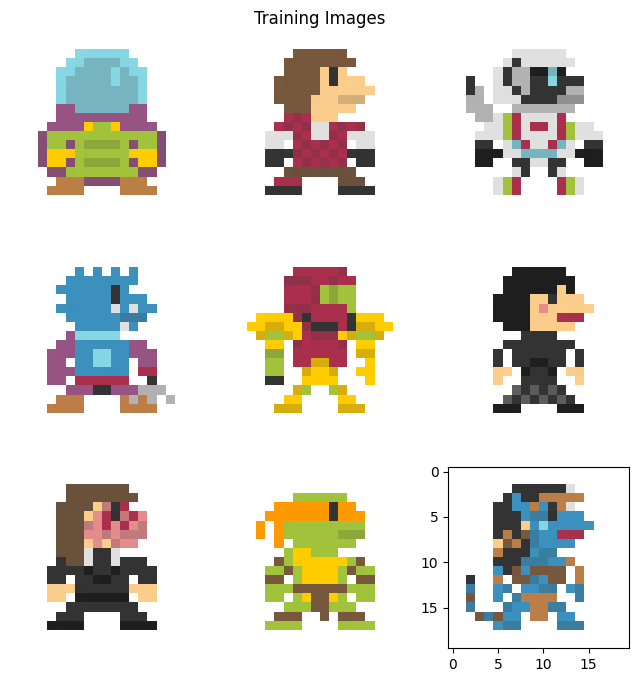

In [13]:
imgs = np.load('8bit_characters_32x32.npz')
 
# pls ignore the poor quality of the images as we are working with 32x32 sized images.
plot_images(imgs['arr_0'], 3)

In [14]:
from torch.utils.data import Dataset, DataLoader

class PixelCharacterDataset(Dataset):
    """Human Faces dataset."""
 
    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs
 
    def __len__(self):
        return len(self.imgs)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image = self.imgs[idx]
 
        return image

In [15]:
transpose_imgs = np.transpose(
    np.float32(imgs['arr_0']), (0, 3, 1, 2)
)
dset = PixelCharacterDataset(transpose_imgs)

dataloader = DataLoader(dset, batch_size=32, shuffle=True)

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # input to generator is something like (batch_size, 100, 1, 1)
        # this means that we are passing a batch of 32 100 random numbers to the generator
        self.model = nn.Sequential(
            # why is in_channels 100?
            # because we are passing 100 random numbers to the generator
            # our latent space is 100 dimensional!
            # first our input is (batch_size, 100, 1, 1)
            # step size is always 1!
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=5, stride=1, padding=0, bias=False),
            # the output of this layer is (batch_size, 512, 5, 5)
            # this is because of the formula for calculating the output size of the image
            # dilation is 1 by default
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
            #                      H_in(1),stride(1),pad(0),kernel(5),output_pad(0)
            # in here, 5 = (1–1) * 1 – 2 * 0 + 1 * (5 –1) + 0 + 1 ; 
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # what is passed here is (batch_size, 512, 4, 4)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            # this is because of the formula for calculating the output size of the image
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
            # H_out = (5    - 1) * 2      - 2 * 1       + 1           * (4              - 1) + 0              + 1
            # H_out = 4 * 2 - 2 + 3 + 1 = 10
            nn.BatchNorm2d(256),
            nn.ReLU(),
        

            # what is passed here is (batch_size, 256, 8, 8)
            nn.ConvTranspose2d(in_channels=256, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            # the output of this layer is (batch_size, 128, 16, 16)
            # this is because of the formula for calculating the output size of the image
            # H_out = (H_in - 1) * stride - 2 * padding + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
            # H_out = (10    - 1) * 2      - 2 * 1       + 1           * (4              - 1) + 0              + 1
            # H_out = 9 * 2 - 2 + 3 + 1 = 20
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)


In [17]:
# test if the wanted dimensions are correct

class ExampleGenerator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 5, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.gen(x)
    
ex_gen = ExampleGenerator()
t = torch.randn(32, 100, 1, 1)
output = ex_gen(t)

print(output.shape)
print(output.type())



torch.Size([32, 3, 20, 20])
torch.FloatTensor


In [18]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            # input is (3, 20, 20)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            # output is (32, 10, 10)
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=32*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32*2),
            nn.LeakyReLU(0.2),
            # output is (64, 5, 5)

            nn.Conv2d(in_channels=64, out_channels=32*4, kernel_size=4, stride=2, padding=1, bias=False),
            # output is (1, 3, 3)
            nn.BatchNorm2d(32*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=32*4, out_channels=1, kernel_size=2, stride=2, padding=0, bias=False),
            # output is (1, 1, 1)
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)
    




In [19]:
ex_dis = Discriminator()
ex_dis(torch.randn(32, 3, 20, 20)).shape


torch.Size([32, 1, 1, 1])

In [20]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [21]:
lr = 0.001 # learning rate
num_epochs = 100 # number of epochs
def backward_hook(grad):
    print(grad)
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (since we are doing binary classification - whether the data is real or fake)


In [22]:
# We will use Adam optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [23]:
for n in enumerate(dataloader):
    print(len(n))
    break

2


torch.cuda.FloatTensor


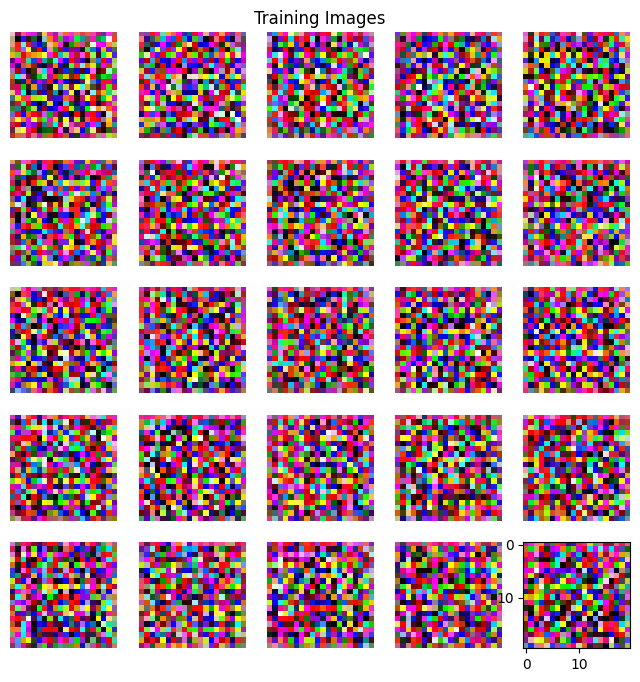

In [24]:
output = generator(torch.randn((32, 100, 1, 1)).to(device))
print(output.type())

img_plot = np.transpose(output.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
img_plot = (img_plot + 1)/2
plot_images(np.array(img_plot).astype(np.float32))



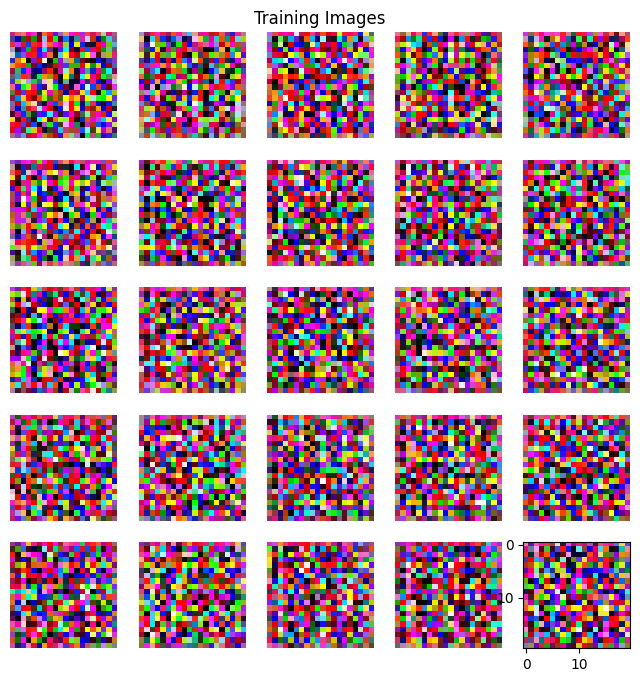

Epoch: 0 Loss D.: 1.4702283143997192
Epoch: 0 Loss G.: 1.5100010633468628


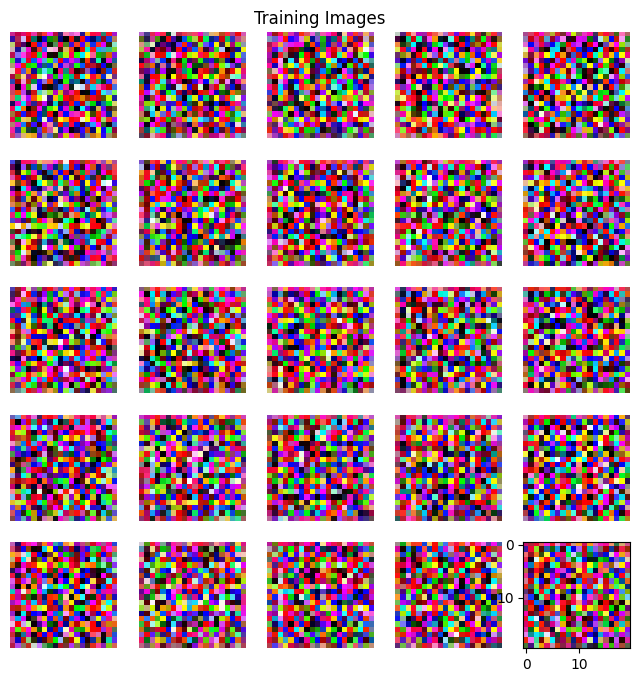

Epoch: 0 Loss D.: 0.4226691722869873
Epoch: 0 Loss G.: 2.3773245811462402


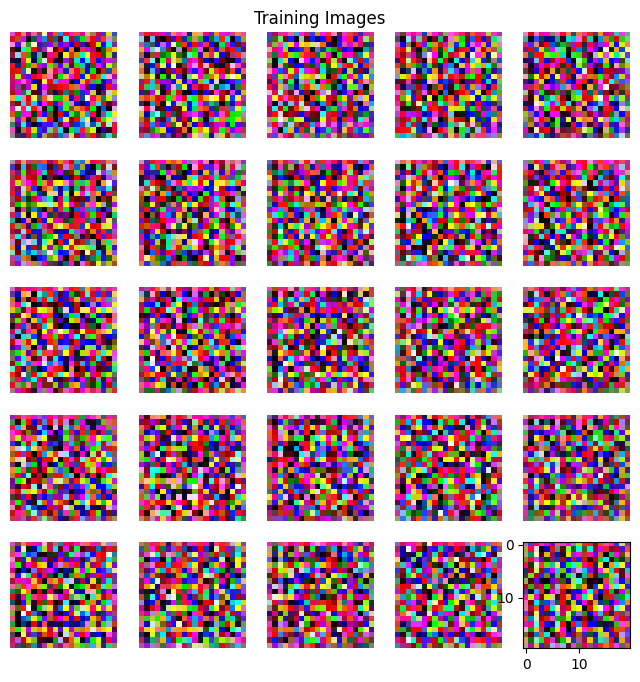

Epoch: 0 Loss D.: 0.15742740035057068
Epoch: 0 Loss G.: 3.122466564178467


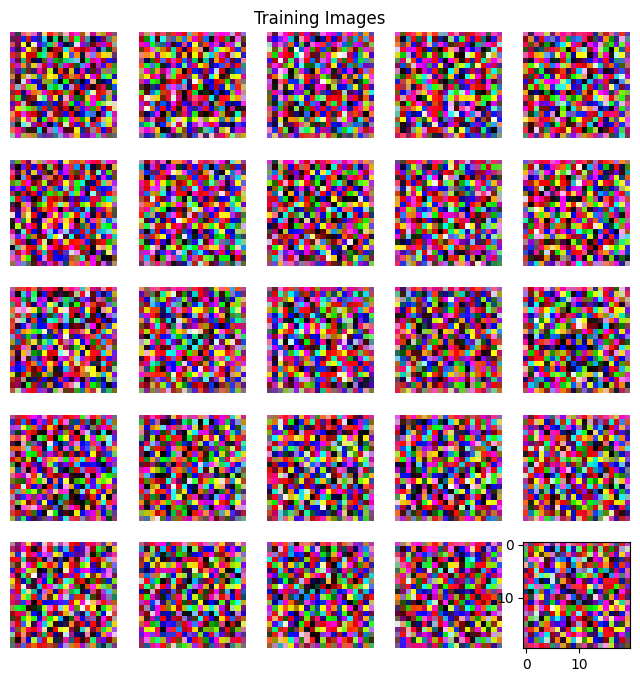

Epoch: 0 Loss D.: 0.08484382182359695
Epoch: 0 Loss G.: 3.5174341201782227


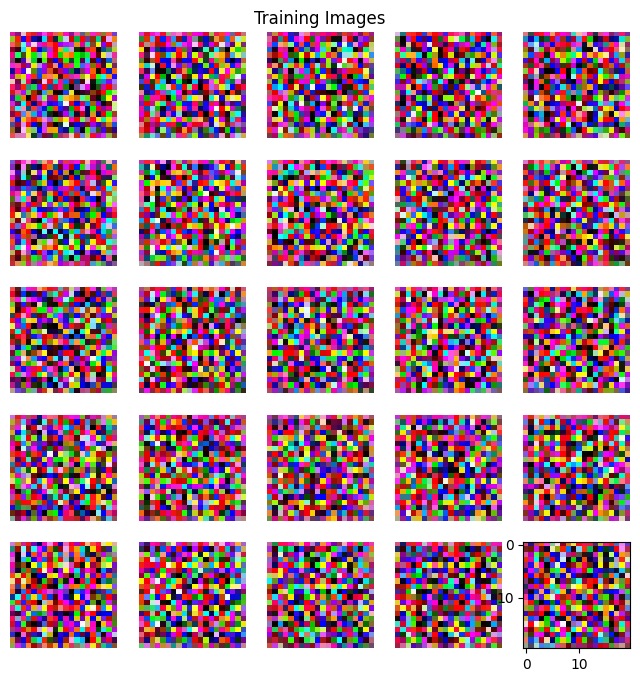

Epoch: 0 Loss D.: 0.04325191304087639
Epoch: 0 Loss G.: 4.002263069152832


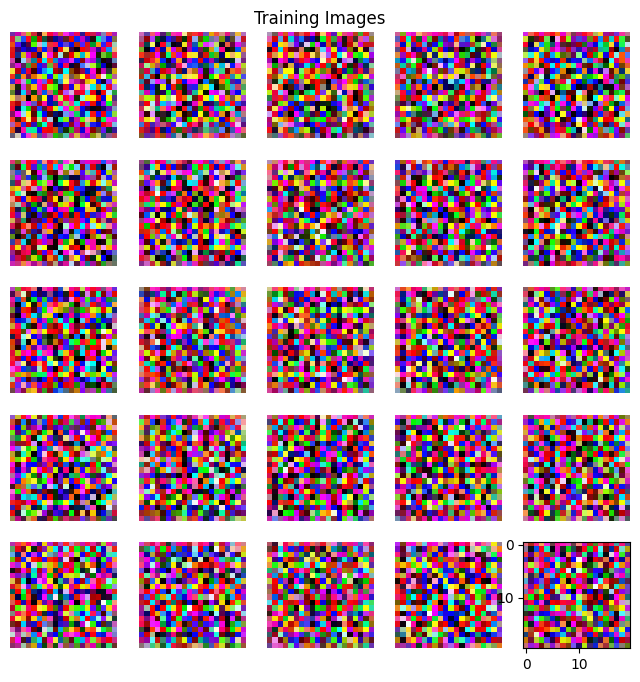

Epoch: 0 Loss D.: 0.031836993992328644
Epoch: 0 Loss G.: 4.261438369750977


KeyboardInterrupt: 

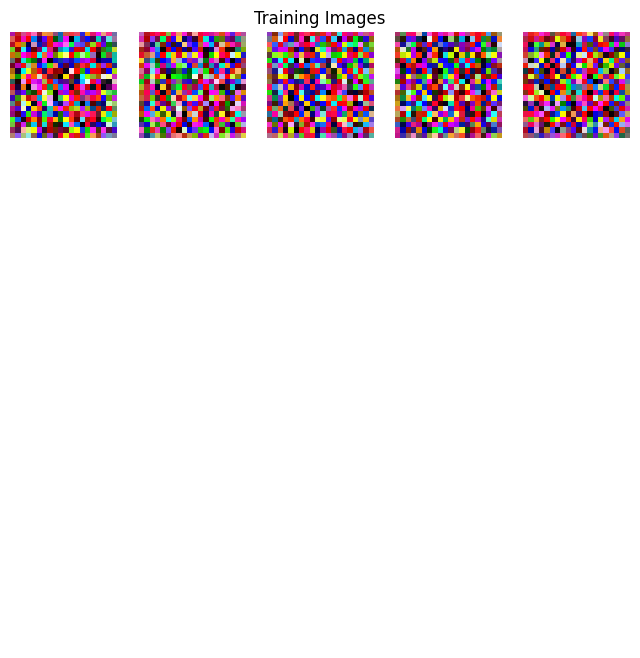

In [25]:
count = 0
batch_size = 32
for epoch in range(10):
    for n, real_samples in enumerate(dataloader):
        ##########################
        ## Update Discriminator ##
        ##########################

        # loss on real data
        optimizer_discriminator.zero_grad()
        real_samples_dis = discriminator(real_samples.to(device)).view(-1)
        real_samples_labels = torch.ones(len(real_samples)).to(device=device)
        loss_real = loss_function(real_samples_dis, real_samples_labels)
        loss_real.backward()

        # loss on fake images
        # generate batch of fake images using Generator
        latent_space_samples = torch.randn((len(real_samples), 100, 1, 1)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_dis = discriminator.cuda()(generated_samples.detach()).view(-1)
        generated_samples_labels = torch.zeros(len(real_samples)).to(device=device)
        loss_fake = loss_function(generated_samples_dis, generated_samples_labels)
        loss_fake.backward()

        loss_disc = loss_real + loss_fake
        optimizer_discriminator.step()

        ##########################
        ## Update Discriminator ##
        ##########################

        optimizer_generator.zero_grad()
        output_discriminator = discriminator.cuda()(generated_samples.detach()).view(-1)
        real_samples_labels = torch.ones(len(real_samples)).to(device=device)
        loss_gen = loss_function(output_discriminator, real_samples_labels)
        loss_gen.backward()
        optimizer_generator.step()

        if epoch % 10 == 0:
            # Visualize the generated digits from the latent space
            img_plot = np.transpose(generated_samples.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            img_plot = np.array(img_plot)
            img_plot = (img_plot + 1) / 2
            plot_images(img_plot)
            print(f"Epoch: {epoch} Loss D.: {loss_disc}")
            print(f"Epoch: {epoch} Loss G.: {loss_gen}")

print(count)